In [132]:
import pandas as pd
import nltk
import tensorflow as tf
import torch
import torch.nn as nn
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!unzip /content/imdb_dataset.zip -d /content/drive/MyDrive
!unzip /content/unlabeled.zip -d /content/drive/MyDrive

Archive:  /content/imdb_dataset.zip
  inflating: /content/drive/MyDrive/imdb_dataset.csv  
Archive:  /content/unlabeled.zip
  inflating: /content/drive/MyDrive/unlabeled.csv  


In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-07-21 08:28:50--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-21 08:28:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.06MB/s    in 2m 42s  

2021-07-21 08:31:31 (5.09 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip /content/glove.6B.zip -d /content/drive/MyDrive/glove_models

Archive:  /content/glove.6B.zip
  inflating: /content/drive/MyDrive/glove_models/glove.6B.50d.txt  
  inflating: /content/drive/MyDrive/glove_models/glove.6B.100d.txt  
  inflating: /content/drive/MyDrive/glove_models/glove.6B.200d.txt  
  inflating: /content/drive/MyDrive/glove_models/glove.6B.300d.txt  


In [124]:
imdb_data = pd.read_csv("/content/drive/MyDrive/imdb_dataset.csv")
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [125]:
unlabled_data = pd.read_csv("/content//drive/MyDrive/unlabeled.csv")
unlabled_data.head()

,ID,Review
0,0,The best part about this movie is that you can...
1,1,This is the Australian TV series. It is a clas...
2,2,"I saw this on TCM recently and, through the IM..."
3,3,Golden Boy is ecchi humor (bordering on hentai...
4,4,If the screenwriter and director intended to o...


In [126]:
unlabled_data.to_csv("/content/test.csv",index=False)

# Data Preprocessing

In [127]:
imdb_data.describe()

,review,sentiment
count,48000,48000
unique,47622,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,24000


In [128]:
imdb_data['sentiment'].value_counts()

positive    24000
negative    24000
Name: sentiment, dtype: int64

(-0.5, 499.5, 299.5, -0.5)

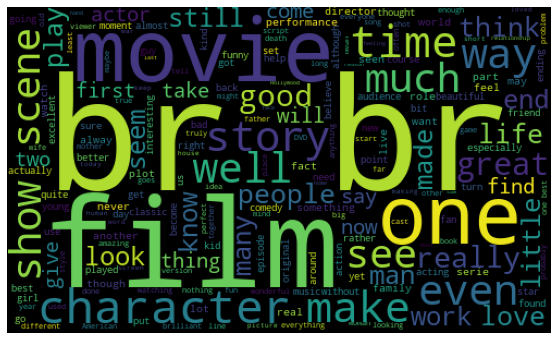

In [129]:
from wordcloud import WordCloud
cloud=WordCloud(width=500, height=300).generate(" ".join(imdb_data[imdb_data['sentiment']=='positive']['review'].to_list()[:10000]))
# join function can help merge all words into one string. " " means space can be a seperator between words.
plt.figure(figsize=(10,6))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 499.5, 299.5, -0.5)

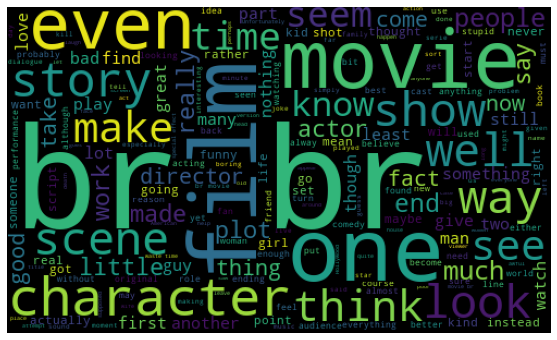

In [130]:
cloud=WordCloud(width=500, height=300).generate(" ".join(imdb_data[imdb_data['sentiment']=='negative']['review']))
# join function can help merge all words into one string. " " means space can be a seperator between words.
plt.figure(figsize=(10,6))
plt.imshow(cloud)
plt.axis('off')

In [133]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [134]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

In [135]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [136]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [137]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'down', 'nor', 'll', 'what', 'does', 'itself', 'on', 'up', "you've", 'we', 'between', 'below', 'him', 'from', 'more', 'now', 'yourself', 'mightn', 'were', 'ain', 'myself', 'whom', 'weren', 'but', "mustn't", "wouldn't", 'who', 'aren', 'as', "aren't", "you'll", 'once', 'her', 'do', 'can', "don't", "doesn't", 'through', 'where', 'won', 'there', 'hasn', 'himself', 'wouldn', 'its', 'during', 'other', 'mustn', 'the', "weren't", 'against', 'she', 'only', "mightn't", 're', 'it', 'how', 'being', 'if', "didn't", 'ourselves', 'this', 'couldn', 'don', 'any', 'until', 'my', 'hers', 'into', 'so', 'having', 'his', 'and', 'herself', "shouldn't", 'when', 'shan', "hadn't", 'they', "you'd", 's', 'your', 'them', 'o', 'not', 'should', 'ours', 'why', 'because', 'is', 'has', 'be', 'most', 'these', 'i', 'was', 'too', 'hadn', "isn't", 'yourselves', 'needn', "needn't", 'same', 'both', 'doing', "that'll", 'am', 'while', 'themselves', 'over', 'out', 'their', "couldn't", 'will', 've', 'he', 'you', 'again', 'than'

In [5]:
# creating train, dev, test split
train = imdb_data[:int(len(imdb_data)*0.8)]
validation = imdb_data[int(len(imdb_data)*0.8):int(len(imdb_data)*1)]

train.to_csv("/content/train.csv", index=False)
validation.to_csv("/content/validation.csv",index=False)

In [6]:
from torchtext.legacy import data
import torchtext

In [7]:
# tokenizer = "spacy" uses spacy's tokenizer
TEXT = data.Field(sequential=True, tokenize="spacy")
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# loading train, test and validation data 
train_data, valid_data, test_data = data.TabularDataset.splits(
    path="/content/", train="train.csv", validation="validation.csv", test="test.csv",format="csv", skip_header=True, 
    fields=[('reviews', TEXT), ('senti', LABEL)]
)

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validating examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 38400
Number of validating examples: 9600
Number of testing examples: 2000


In [11]:
TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors("/content/drive/MyDrive/glove_models/glove.6B.300d.txt"), 
                 max_size=25000, min_freq=1)
LABEL.build_vocab(train_data)

100%|█████████▉| 399549/400000 [00:40<00:00, 9355.99it/s]

In [27]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [28]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator,test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.reviews),
    batch_size=BATCH_SIZE,
    device=device)

cuda


In [38]:
def binary_accuracy(preds, y):
    
    preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
    correct = (ind == y).float()
    acc = correct.sum()/float(len(correct))

    return acc

In [39]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        # batch, batch_lengths = batch.reviews

        predictions = model(batch.reviews).squeeze(0)

        loss = criterion(predictions, batch.senti)

        acc = binary_accuracy(predictions, batch.senti)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [40]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for batch in iterator:

            predictions = model(batch.reviews).squeeze(0)
            
            loss = criterion(predictions, batch.senti)
            
            acc = binary_accuracy(predictions, batch.senti)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [45]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# RNN_MODEL

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        

        output, hidden = self.rnn(embedded)
        
       
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        hidden = self.dropout(hidden)
        
        out = self.fc(hidden)
        return out

In [ ]:
INPUT_DIM =  len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 2
DROPOUT = 0.2

model_rnn = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_rnn.embedding.weight.data = pretrained_embeddings.cuda()


class_weights = torch.tensor([1.0, 1.0]).cuda()


optimizer = optim.SGD(model_rnn.parameters(), lr=0.00005)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_rnn = model_rnn.to(device)
criterion = criterion.to(device)

torch.Size([25002, 300])


In [ ]:
N_EPOCHS = 10
train_rnn_loss = []
train_rnn_acc = []
valid_rnn_loss = []
valid_rnn_acc = []
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model_rnn, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_rnn, valid_iterator, criterion)
    
    train_rnn_loss.append(train_loss)
    train_rnn_acc.append(train_acc)

    valid_rnn_loss.append(valid_loss)
    valid_rnn_acc.append(valid_acc)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    
    torch.save(model_rnn.state_dict(), 'Rnn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 49s
	Train Loss: 0.694 | Train Acc: 49.92%
	 Val. Loss: 0.693 |  Val. Acc: 51.20%
Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 0.694 | Train Acc: 49.94%
	 Val. Loss: 0.693 |  Val. Acc: 51.16%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.694 | Train Acc: 49.96%
	 Val. Loss: 0.693 |  Val. Acc: 51.19%
Epoch: 04 | Epoch Time: 0m 48s
	Train Loss: 0.694 | Train Acc: 49.88%
	 Val. Loss: 0.693 |  Val. Acc: 51.21%
Epoch: 05 | Epoch Time: 0m 48s
	Train Loss: 0.694 | Train Acc: 49.94%
	 Val. Loss: 0.693 |  Val. Acc: 51.16%
Epoch: 06 | Epoch Time: 0m 49s
	Train Loss: 0.693 | Train Acc: 50.03%
	 Val. Loss: 0.693 |  Val. Acc: 51.06%
Epoch: 07 | Epoch Time: 0m 48s
	Train Loss: 0.693 | Train Acc: 49.85%
	 Val. Loss: 0.693 |  Val. Acc: 51.22%
Epoch: 08 | Epoch Time: 0m 49s
	Train Loss: 0.694 | Train Acc: 49.84%
	 Val. Loss: 0.693 |  Val. Acc: 50.85%
Epoch: 09 | Epoch Time: 0m 49s
	Train Loss: 0.693 | Train Acc: 50.09%
	 Val. Loss: 0.693 |  Val. Acc: 50.74%


In [ ]:
epochs = list(range(1,11))

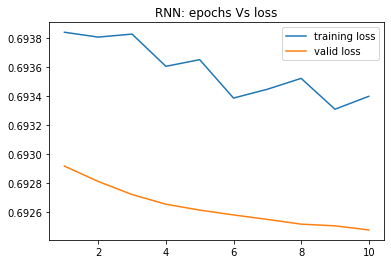

In [ ]:
plt.plot(epochs, train_rnn_loss, label='training loss')
plt.plot(epochs, valid_rnn_loss, label='valid loss')
plt.title("RNN: epochs Vs loss")
plt.legend()
plt.show()

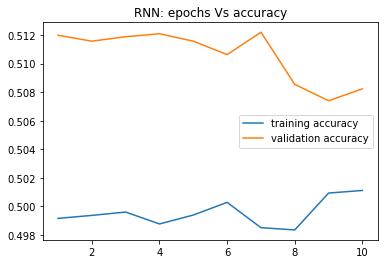

In [ ]:
plt.plot(epochs, train_rnn_acc, label='training accuracy')
plt.plot(epochs, valid_rnn_acc, label='validation accuracy')
plt.title("RNN: epochs Vs accuracy")
plt.legend()
plt.show()

# LSTM_MODEL

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        
        
        embedded = self.dropout(self.embedding(x))
        
        output, (hidden,cell) = self.rnn(embedded)
       
        hidden = self.dropout(hidden)
        
        out = self.fc(hidden)
        
        return out

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 2
DROPOUT = 0.2

model_lstm = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_lstm.embedding.weight.data = pretrained_embeddings.cuda()

class_weights = torch.tensor([1.0, 1.0]).cuda()

optimizer = optim.Adam(model_lstm.parameters(), lr=0.00005)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_lstm = model_lstm.to(device)
criterion = criterion.to(device)

torch.Size([25002, 300])


In [ ]:
N_EPOCHS = 10
train_lstm_loss = []
train_lstm_acc = []
valid_lstm_loss = []
valid_lstm_acc = []
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model_lstm, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_lstm, valid_iterator, criterion)
    
    train_lstm_loss.append(train_loss)
    train_lstm_acc.append(train_acc)

    valid_lstm_loss.append(valid_loss)
    valid_lstm_acc.append(valid_acc)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    
    torch.save(model_lstm.state_dict(), 'Lstm-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 20s
	Train Loss: 0.693 | Train Acc: 50.04%
	 Val. Loss: 0.690 |  Val. Acc: 54.92%
Epoch: 02 | Epoch Time: 1m 21s
	Train Loss: 0.693 | Train Acc: 50.15%
	 Val. Loss: 0.684 |  Val. Acc: 57.94%
Epoch: 03 | Epoch Time: 1m 21s
	Train Loss: 0.692 | Train Acc: 50.42%
	 Val. Loss: 0.672 |  Val. Acc: 59.14%
Epoch: 04 | Epoch Time: 1m 22s
	Train Loss: 0.690 | Train Acc: 50.69%
	 Val. Loss: 0.590 |  Val. Acc: 69.51%
Epoch: 05 | Epoch Time: 1m 22s
	Train Loss: 0.689 | Train Acc: 50.28%
	 Val. Loss: 0.627 |  Val. Acc: 67.73%
Epoch: 06 | Epoch Time: 1m 22s
	Train Loss: 0.688 | Train Acc: 50.77%
	 Val. Loss: 0.600 |  Val. Acc: 68.90%
Epoch: 07 | Epoch Time: 1m 22s
	Train Loss: 0.689 | Train Acc: 50.70%
	 Val. Loss: 0.630 |  Val. Acc: 62.15%
Epoch: 08 | Epoch Time: 1m 23s
	Train Loss: 0.687 | Train Acc: 50.99%
	 Val. Loss: 0.522 |  Val. Acc: 75.34%
Epoch: 09 | Epoch Time: 1m 23s
	Train Loss: 0.686 | Train Acc: 50.76%
	 Val. Loss: 0.522 |  Val. Acc: 75.74%
Epoch: 10 | Epoch T

In [ ]:
epochs = list(range(1,11))

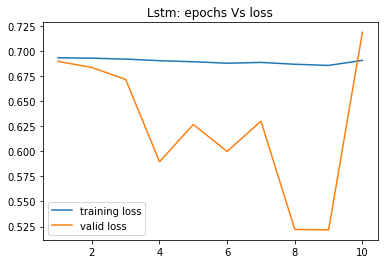

In [ ]:
plt.plot(epochs, train_lstm_loss, label='training loss')
plt.plot(epochs, valid_lstm_loss, label='valid loss')
plt.title("Lstm: epochs Vs loss")
plt.legend()
plt.show()

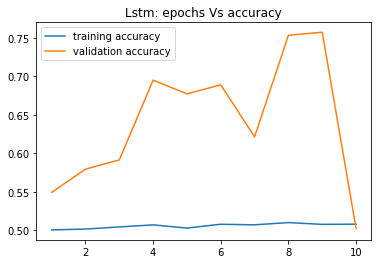

In [ ]:
plt.plot(epochs, train_lstm_acc, label='training accuracy')
plt.plot(epochs, valid_lstm_acc, label='validation accuracy')
plt.title("Lstm: epochs Vs accuracy")
plt.legend()
plt.show()

# GRU_MODEL

In [41]:
class GRU(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        
        
        embedded = self.dropout(self.embedding(x))
        
        output, hidden = self.rnn(embedded)
        
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        hidden = self.dropout(hidden)
        
        out = self.fc(hidden)
       
        return out

In [42]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 2
DROPOUT = 0.5

model_gru = GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [44]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_gru.embedding.weight.data = pretrained_embeddings.cuda()

class_weights = torch.tensor([1.0, 1.0]).cuda()

optimizer = optim.Adam(model_gru.parameters(), lr=0.00003)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_gru = model_gru.to(device)
criterion = criterion.to(device)

torch.Size([25002, 300])


In [46]:
N_EPOCHS = 10
train_gru_loss = []
train_gru_acc = []
valid_gru_loss = []
valid_gru_acc = []
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model_gru, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_gru, valid_iterator, criterion)
    
    train_gru_loss.append(train_loss)
    train_gru_acc.append(train_acc)

    valid_gru_loss.append(valid_loss)
    valid_gru_acc.append(valid_acc)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    
    torch.save(model_gru.state_dict(), 'Gru-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 25s
	Train Loss: 0.693 | Train Acc: 49.74%
	 Val. Loss: 0.691 |  Val. Acc: 52.65%
Epoch: 02 | Epoch Time: 1m 24s
	Train Loss: 0.693 | Train Acc: 50.15%
	 Val. Loss: 0.688 |  Val. Acc: 53.39%
Epoch: 03 | Epoch Time: 1m 25s
	Train Loss: 0.693 | Train Acc: 50.20%
	 Val. Loss: 0.686 |  Val. Acc: 53.25%
Epoch: 04 | Epoch Time: 1m 25s
	Train Loss: 0.693 | Train Acc: 50.57%
	 Val. Loss: 0.682 |  Val. Acc: 54.72%
Epoch: 05 | Epoch Time: 1m 24s
	Train Loss: 0.693 | Train Acc: 50.05%
	 Val. Loss: 0.674 |  Val. Acc: 59.50%
Epoch: 06 | Epoch Time: 1m 25s
	Train Loss: 0.692 | Train Acc: 49.91%
	 Val. Loss: 0.664 |  Val. Acc: 58.71%
Epoch: 07 | Epoch Time: 1m 26s
	Train Loss: 0.691 | Train Acc: 50.74%
	 Val. Loss: 0.620 |  Val. Acc: 65.90%
Epoch: 08 | Epoch Time: 1m 27s
	Train Loss: 0.689 | Train Acc: 51.01%
	 Val. Loss: 0.618 |  Val. Acc: 67.40%
Epoch: 09 | Epoch Time: 1m 27s
	Train Loss: 0.688 | Train Acc: 51.32%
	 Val. Loss: 0.698 |  Val. Acc: 70.71%
Epoch: 10 | Epoch T

In [47]:
epochs = list(range(1,11))

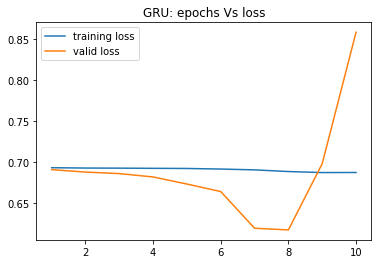

In [48]:
plt.plot(epochs, train_gru_loss, label='training loss')
plt.plot(epochs, valid_gru_loss, label='valid loss')
plt.title("GRU: epochs Vs loss")
plt.legend()
plt.show()

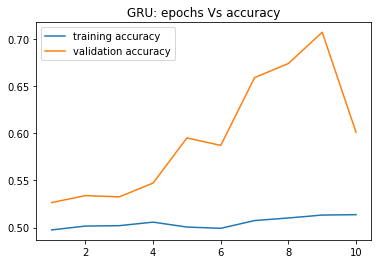

In [49]:
plt.plot(epochs, train_gru_acc, label='training accuracy')
plt.plot(epochs, valid_gru_acc, label='validation accuracy')
plt.title("GRU: epochs Vs accuracy")
plt.legend()
plt.show()

# PREDICTION

In [50]:
def predict_sentiment(model,sentence):
    tokenized = [tok for tok in sentence.split()]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    tensor = tensor.unsqueeze(1)
#     print(tensor.shape)
    prediction = model(tensor)
#     print(prediction)
    preds = torch.round(torch.sigmoid(prediction))
#     print(preds)
    return preds

In [70]:
test_data = pd.read_csv('test.csv')

In [71]:
pre = [torch.argmax(predict_sentiment(model_gru,k)).cpu().tolist() for k in test_data.Review]

In [72]:
test_data.Review

0       The best part about this movie is that you can...
1       This is the Australian TV series. It is a clas...
2       I saw this on TCM recently and, through the IM...
3       Golden Boy is ecchi humor (bordering on hentai...
4       If the screenwriter and director intended to o...
                              ...                        
1995    This is your typical junk comedy.<br /><br />T...
1996    Bad plot, bad dialogue, bad acting, idiotic di...
1997    I am a Catholic taught in parochial elementary...
1998    I'm going to have to disagree with the previou...
1999    No one expects the Star Trek movies to be high...
Name: Review, Length: 2000, dtype: object

In [ ]:
pre

In [108]:
new_df= pd.DataFrame()
new_df['RevID'] = test_data['ID']
new_df['reviews'] = test_data['Review']
new_df['sentiments'] = pre
new_df.to_csv('Msds20030_Gru_predications.csv', index= False)

In [109]:
Pre_data = pd.read_csv('Msds20030_Gru_predications.csv')

In [110]:
Pre_data.head()

,RevID,reviews,sentiments
0,0,The best part about this movie is that you can...,1
1,1,This is the Australian TV series. It is a clas...,1
2,2,"I saw this on TCM recently and, through the IM...",1
3,3,Golden Boy is ecchi humor (bordering on hentai...,1
4,4,If the screenwriter and director intended to o...,1


In [111]:
Pre_data.sentiments[Pre_data.sentiments == 1] = 'Positive'
Pre_data.sentiments[Pre_data.sentiments == 0] = 'Negative'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
Pre_data

,RevID,reviews,sentiments
0,0,The best part about this movie is that you can...,Positive
1,1,This is the Australian TV series. It is a clas...,Positive
2,2,"I saw this on TCM recently and, through the IM...",Positive
3,3,Golden Boy is ecchi humor (bordering on hentai...,Positive
4,4,If the screenwriter and director intended to o...,Positive
...,...,...,...
1995,1995,This is your typical junk comedy.<br /><br />T...,Positive
1996,1996,"Bad plot, bad dialogue, bad acting, idiotic di...",Negative
1997,1997,I am a Catholic taught in parochial elementary...,Positive
1998,1998,I'm going to have to disagree with the previou...,Positive


(-0.5, 499.5, 299.5, -0.5)

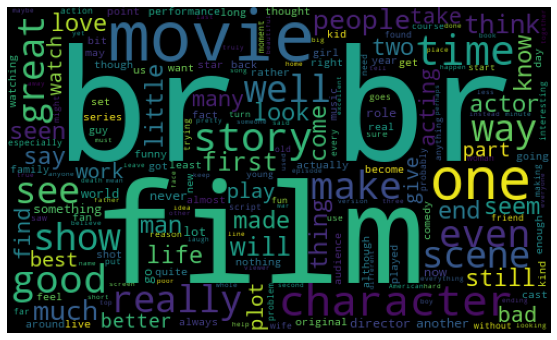

In [89]:
cloud=WordCloud(width=500, height=300).generate(" ".join(Pre_data[Pre_data['sentiments']=='Positive']['reviews']))
# join function can help merge all words into one string. " " means space can be a seperator between words.
plt.figure(figsize=(10,6))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 499.5, 299.5, -0.5)

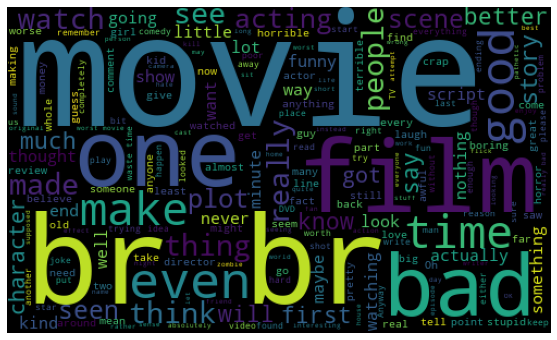

In [91]:
cloud=WordCloud(width=500, height=300).generate(" ".join(Pre_data[Pre_data['sentiments']=='Negative']['reviews']))
# join function can help merge all words into one string. " " means space can be a seperator between words.
plt.figure(figsize=(10,6))
plt.imshow(cloud)
plt.axis('off')